### Question 1 EDA

This EDA graph for question 1 was moved here due to the large amount of data needed to be read and joined

In [55]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

In [57]:
def eda(data):
    df = data.copy()
    df = df[['Region', 'UTC time', 'Local date', 'Hour', 'Local time', 'Time zone',
                         'DF', 'D', 'Sum (NG)', 'NG: COL', 'NG: NG', 'NG: NUC',
                         'NG: OIL', 'NG: WAT', 'NG: SUN', 'NG: WND', 'NG: OTH', 'CO2 Emissions Generated']]
    df['Local date'] = pd.to_datetime(df['Local date'], format='%d%b%Y')
    df['day'] = df['Local date'].dt.day
    df['month'] = df['Local date'].dt.month
    df['year'] = df['Local date'].dt.year
    df['dotw'] = df['Local date'].dt.dayofweek
    df = df[(df['year'] >= 2016) & (df['year'] <= 2023)]
    df['Hour'] = df['Hour'] - 1
    df['D'] = pd.to_numeric(df['D'].str.replace(',', '', regex=False), errors='coerce')
    return df

In [59]:
california = eda(pd.read_csv('california.csv', low_memory=False))

In [60]:
weather_master = pd.read_csv('weather_master.csv')

weather_master = weather_master[['TMAX', 'DATE']]
weather_master = weather_master.groupby('DATE').mean().reset_index()
california = california[['D', 'Hour', 'Local date']]

In [61]:
california['Local date'] = pd.to_datetime(california['Local date']).dt.date
weather_master['DATE'] = pd.to_datetime(weather_master['DATE']).dt.date

In [62]:
merged = pd.merge(
        california,
        weather_master,
        left_on="Local date",
        right_on="DATE",
        how="right"
    )
merged

,D,Hour,Local date,DATE,TMAX
0,29187,0,2016-01-01,2016-01-01,46.576471
1,28364,1,2016-01-01,2016-01-01,46.576471
2,27465,2,2016-01-01,2016-01-01,46.576471
3,26813,3,2016-01-01,2016-01-01,46.576471
4,26509,4,2016-01-01,2016-01-01,46.576471
...,...,...,...,...,...
67171,30872,19,2023-12-31,2023-12-31,53.683453
67172,30005,20,2023-12-31,2023-12-31,53.683453
67173,29218,21,2023-12-31,2023-12-31,53.683453
67174,28657,22,2023-12-31,2023-12-31,53.683453


In [67]:
# Step 1: Calculate the 95th percentile of TMAX
tmax_95th_percentile = merged['TMAX'].quantile(0.95)

# Step 2: Filter the DataFrame for days with TMAX in the 5th percentile highest temperatures
merged['Extreme'] = merged['TMAX'] >= tmax_95th_percentile

# Display the filtered DataFrame
merged

,D,Hour,Local date,DATE,TMAX,Extreme
0,29187,0,2016-01-01,2016-01-01,46.576471,False
1,28364,1,2016-01-01,2016-01-01,46.576471,False
2,27465,2,2016-01-01,2016-01-01,46.576471,False
3,26813,3,2016-01-01,2016-01-01,46.576471,False
4,26509,4,2016-01-01,2016-01-01,46.576471,False
...,...,...,...,...,...,...
67171,30872,19,2023-12-31,2023-12-31,53.683453,False
67172,30005,20,2023-12-31,2023-12-31,53.683453,False
67173,29218,21,2023-12-31,2023-12-31,53.683453,False
67174,28657,22,2023-12-31,2023-12-31,53.683453,False


In [83]:
merged['Local date'] = pd.to_datetime(merged['Local date'])
merged['dotw'] = merged['Local date'].dt.weekday

In [85]:
demand_by_hour_non_extreme = merged[merged['Extreme'] == False][['Hour', 'D']].groupby('Hour').mean()
demand_by_hour_non_extreme = demand_by_hour_non_extreme.drop(demand_by_hour_non_extreme.index[-1])

demand_by_hour_extreme = merged[merged['Extreme'] == True][['Hour', 'D']].groupby('Hour').mean()
demand_by_hour_extreme = demand_by_hour_extreme.drop(demand_by_hour_extreme.index[-1])

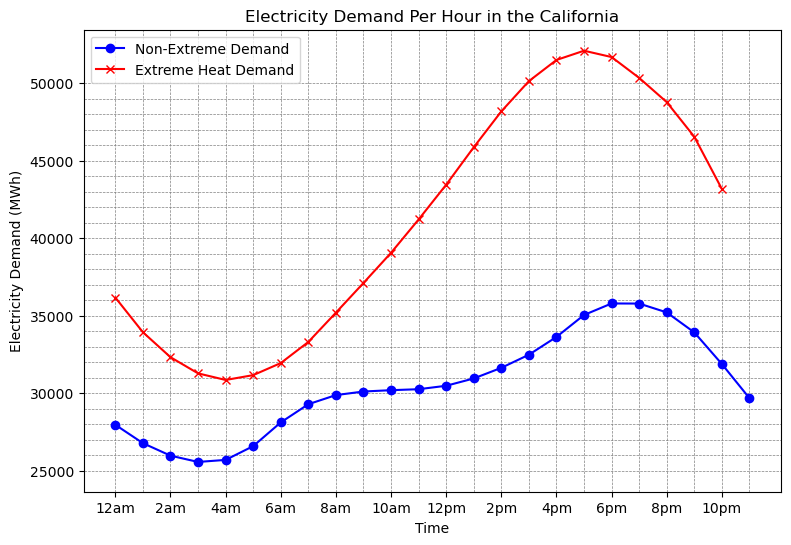

In [93]:
fig, ax = plt.subplots(figsize=(9, 6))
for y in np.arange(25000, 50000 + 1, 1000):
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)
for x in np.arange(0, 23 + 1, 1):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(0, 24, 2), ['12am', '2am', '4am', '6am', '8am', '10am', '12pm', '2pm', '4pm', '6pm', '8pm', '10pm'])
plt.plot(demand_by_hour.index, demand_by_hour_non_extreme['D'], label='Non-Extreme Demand', color='blue', marker='o')
plt.plot(demand_by_hour_extreme.index, demand_by_hour_extreme['D'], label='Extreme Heat Demand', color='red', marker='x')
plt.xlabel('Time')
plt.ylabel('Electricity Demand (MWh)')
plt.legend()
plt.title('Electricity Demand Per Hour in the California')
plt.savefig("EDA_Q1.png");

This graph (in MWh) demonstrates that on average, at all times of the day electricity demand is higher on days exhibiting "extreme heat". The biggest difference in the graph between the two is at around 4-6 PM, which also lines up with what are generally the peak electricity demand hours. We will determine to what extent this difference we see in this graph is causal. 